In [1]:
import numpy as np
import matplotlib.mlab as mlab
import math


def get_peak(size, loc, sig, max_height):
    m = np.mgrid[:size[0], :size[1]]
    biv = mlab.bivariate_normal(m[0], m[1], sig[0], sig[1], loc[0], loc[1])
    return (biv*float(max_height)/biv.max()).astype(int)


class Landscape:
    def __init__(self, width, height, num_peaks, peak_clustering, max_value, total_value):
        self.width = width
        self.height = height
        self.num_peaks = num_peaks
        self.peak_clustering = peak_clustering
        self.max_value = max_value
        self.total_value = total_value
        # Generate a random landscape
        landscape = np.zeros((width, height)).astype(int)
        peak_min_size = math.ceil(0.3 * ((width * height)**0.5 / float(num_peaks)))
        peak_max_size = max(peak_min_size + 1, math.ceil(0.5 * ((width * height)**0.5 / float(num_peaks))))
        for i in range(num_peaks):
            x = np.random.randint(int(peak_clustering * 0.5 * width), width - int(peak_clustering * 0.5 * width) + 1)
            y = np.random.randint(int(peak_clustering * 0.5 * height), height - int(peak_clustering * 0.5 * height) + 1)
            w = np.random.randint(peak_min_size, peak_max_size)
            h = np.random.randint(peak_min_size, peak_max_size)
            landscape += get_peak((width, height), (x,y), (w, h), max_value)
        current_total_value = float(np.sum(landscape))
        self.landscape = (landscape * (total_value/current_total_value)).astype(int)

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

import random


def poly_area(points):
    if len(points) == 0:
        return 0
    elif len(points) == 1:
        return 0.01
    elif len(points) == 2:
        return 0.01 * ((points[0][0] - points[1][0])**2 + (points[0][1] - points[1][1])**2)**0.5
    else:
        xs, ys = zip(*points)
        return 0.5*np.abs(np.dot(xs,np.roll(ys,1))-np.dot(ys,np.roll(xs,1)))


class Publication(object):
    def __init__(self, evidence, strategy):
        self.evidence = list(evidence)
        self.strategy = strategy
    
    @property
    def quantity(self):
        return len(self.evidence)
    
    @property
    def quality(self):
        return sum([e[1] for e in self.evidence])
    
    @property
    def disparity(self):
        return poly_area([e[0] for e in self.evidence])
    
    def __str__(self):
        return "P(%s, q=%d, d=%.2f)" % (self.strategy, self.quality, self.disparity)
    
    __repr__ = __str__


class Scientist(Agent):
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.strategy = None
        self.counter = 1
        self.evidence = []
        self.publications = []
        self.vision = None
    
    def set_strategy(self, strategy):
        self.strategy = strategy
        if strategy == 'omnivorous':
            self.actions = (
                ['generate'] * 1 +
                ['explore'] * 2 +
                ['exploit'] * 1 +
                ['submit'] * 1
            )
        elif strategy == 'obligate':
            self.actions = (
                ['generate'] * 4 +
                ['explore'] * 1 +
                ['exploit'] * 4 +
                ['submit'] * 2
            )
        else:
            raise ValueError("Unknown strategy: %s" % strategy)
        self.current_actions = list(self.actions)
    
    def step(self, model):
        if self.strategy is None:
            raise ValueError("No strategy set for agent %d" % self.unique_id)
        self.counter -= 1
        if self.vision is None:
            self.vision = np.zeros((model.grid.width, model.grid.height))
            self.update_vision(model)
        
        if self.counter > 0:
            return
        action = random.choice(self.current_actions)
        self.current_actions.remove(action)
        if action == 'generate':
            self.counter = 6
            self.generate(model)
            self.exploit(model)  # one free exploit at the end of generation - priority
        else:
            self.counter = 1
            if action == 'explore':
                self.explore(model)
            elif action == 'exploit':
                self.exploit(model)
            elif action == 'submit':
                self.submit(model)
            else:
                raise ValueError("Unknown action: %s" % action)
        self.current_actions = list(self.actions)
    
    def generate(self, model):
        if model.landscape[self.pos] < model.landscape_potential[self.pos]:
            model.landscape += get_peak(
                (model.grid.width, model.grid.height),
                self.pos,
                (2,2),
                max(1, int(model.landscape_potential[self.pos] - model.landscape[self.pos])))
        x = random.randrange(0, model.grid.width)
        y = random.randrange(0, model.grid.height)
        if model.landscape[(x, y)] < model.landscape_potential[(x, y)]:
            model.landscape += get_peak(
                (model.grid.width, model.grid.height),
                (x, y),
                (2, 2),
                max(1, int(model.landscape_potential[(x, y)] - model.landscape[(x, y)])))
    
    def explore(self, model):
        unknown_locales = list(zip(*np.nonzero(self.vision == 0)))
        random.shuffle(unknown_locales)
        if unknown_locales:
            new_pos = random.choice(unknown_locales)
            model.grid.move_agent(self, new_pos)
            self.update_vision(model)
        else:
            self.step(model)
    
    def exploit(self, model):
        known_locales = list(zip(*np.nonzero(self.vision)))
        random.shuffle(known_locales)
        
        if self.strategy == 'omnivorous':
            method = 'area'
        elif self.strategy == 'obligate':
            method = 'quantity'
        else:
            raise ValueError("Unknown strategy: %s" % strategy)
        
        if method == 'quantity':
            best, pos = self.pick_most_abundant_locale(model, known_locales)
        elif method == 'area':
            best, pos = self.pick_most_area_increasing_locale(model, known_locales)
        else:
            raise ValueError("Uknown method: %s" % method)
        
        if best > 0 and pos != -1:
            self.evidence.append((pos, model.landscape[pos]))
            model.landscape[pos] -= min(model.landscape[pos], model.max_value//5)
        else:
            self.step(model)

    def submit(self, model):
        if ((self.strategy == 'omnivorous' and 
             poly_area([e[0] for e in self.evidence]) >= (
                    model.omni_threshold * model.grid.width * model.grid.height)) or 
            (self.strategy == 'obligate' and 
             sum([e[1] for e in self.evidence]) > (model.obli_threshold * model.max_value))):
            p = Publication(self.evidence, self.strategy)
            self.publications.append(p)
            self.evidence = []
        else:
            self.step(model)
            
    def pick_most_abundant_locale(self, model, known_locales):
        best = 0
        pos = -1
        for locale in known_locales:
            if model.landscape[locale] > best:
                best = model.landscape[locale]
                pos = locale
        return best, pos
    
    def pick_most_area_increasing_locale(self, model, known_locales):
        if not self.evidence:
            return 1, known_locales[0]
        best = poly_area([e[0] for e in self.evidence])
        pos = -1
        for locale in known_locales:
            if (model.landscape[locale] > 0) and (poly_area([e[0] for e in self.evidence] + [locale]) > best):
                best = poly_area([e[0] for e in self.evidence] + [locale])
                pos = locale
        return best, pos
    
    def update_vision(self, model):
        for pos in model.grid.get_neighborhood(self.pos, moore=True, include_center=True, radius=5):
            self.vision[pos] = 1


class DiversityModel(Model):
    def __init__(self,
                 num_agents,
                 init_omni_ratio,
                 landscape,
                 episode_length,
                 omni_threshold = 0.2,
                 obli_threshold = 3,
                 continue_after_uniform = False):
        self.num_agents = num_agents
        self.omni_threshold = omni_threshold
        self.obli_threshold = obli_threshold
        self.max_value = landscape.max_value
        self.width = landscape.width
        self.height = landscape.height
        self.episode_length = episode_length
        self.num_peaks = landscape.num_peaks
        self.continue_after_uniform = continue_after_uniform
        self.step_counter = 0
        self.datacollector = DataCollector(model_reporters={
                'Omni ratio': omni_ratio
            })
        self.landscape_potential = landscape.landscape
        self.landscape = (self.landscape_potential.copy()/(self.max_value/3)).astype(int)
        self.seed_agents()
        self.set_agent_strategies(init_omni_ratio)
        self.running = True
        
    def seed_agents(self):
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(self.width, self.height, False)  # Non-toroidal grid
        for i in range(self.num_agents):
            a = Scientist(i)
            self.schedule.add(a)
            x = random.randrange(0, self.grid.width)
            y = random.randrange(0, self.grid.height)
            self.grid.place_agent(a, (x, y))
    
    def set_agent_strategies(self, omni_ratio):
        if omni_ratio in [0, 1]:
            self.running = self.continue_after_uniform
        target_num_omnis = int(omni_ratio*self.num_agents)
        for i, agent in enumerate(self.schedule.agents):
            if i < target_num_omnis:
                agent.set_strategy('omnivorous')
            else:
                agent.set_strategy('obligate')
    
    def step(self):
        self.datacollector.collect(self)
        self.step_counter += 1
        if not (self.step_counter % self.episode_length):
            om_r = omni_ratio(self)
            self.set_agent_strategies(om_r)
        self.schedule.step()

def omni_ratio(model):
    pubs = count_publications(model)
    if pubs['omni'][0] + pubs['obli'][0] == 0:
        fudge = 0.01
    else:
        fudge = 0
    return float(pubs['omni'][0]) / (pubs['omni'][0] + pubs['obli'][0] + fudge)
        
def count_publications(model):
    omni_results = [0, [], []]
    obli_results = [0, [], []]
    for agent in model.schedule.agents:
        for p in agent.publications:
            if p.strategy == 'omnivorous':
                omni_results[0] += 1
                omni_results[1].append(p.quality)
                omni_results[2].append(p.disparity)
            elif p.strategy == 'obligate':
                obli_results[0] += 1
                obli_results[1].append(p.quality)
                obli_results[2].append(p.disparity)
            else:
                raise KeyError()
    return {
        'omni': omni_results,
        'obli': obli_results
    }

def count_total_publications(model):
    res = count_publications(model)
    return res['omni'][0] + res['obli'][0]

def count_total_quality(model):
    res = count_publications(model)
    return sum(res['omni'][1]) + sum(res['obli'][1])

def count_total_disparity(model):
    res = count_publications(model)
    return sum(res['omni'][2]) + sum(res['obli'][2])

def quality_disparity_ratio(model):
    return count_total_quality(model) / count_total_disparity(model)

def count_obli_quality(model):
    return sum(count_publications(model)['obli'][1])

def count_omni_disparity(model):
    return sum(count_publications(model)['omni'][2])

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import statistics

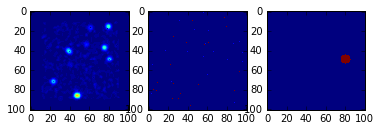

num omni: 20 / 40


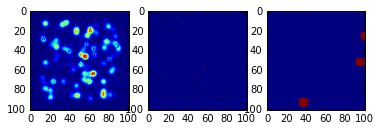

num omni: 20 / 40


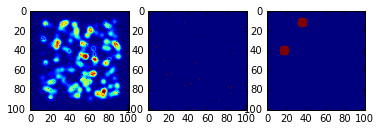

num omni: 20 / 40


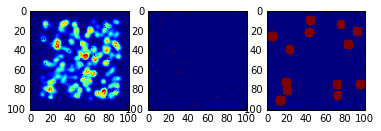

num omni: 17 / 40


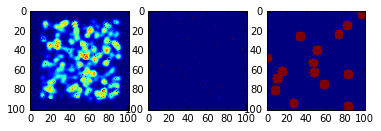

num omni: 17 / 40


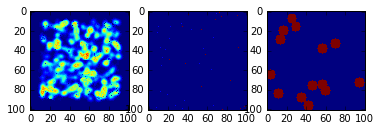

num omni: 17 / 40


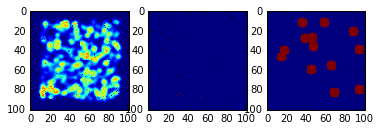

num omni: 18 / 40


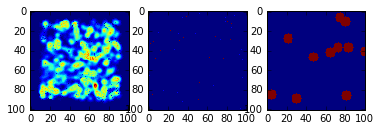

num omni: 18 / 40


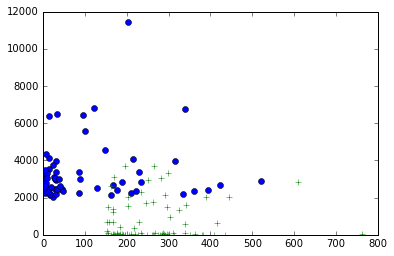

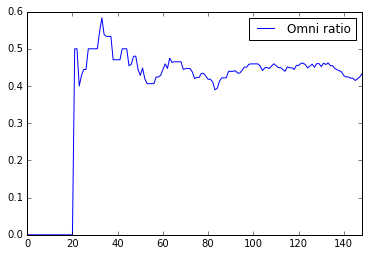

In [9]:
landscape = Landscape(
    width=101, 
    height=101, 
    max_value=50,
    total_value=100000,
    num_peaks=1000,
    peak_clustering=0.25
)

model = DiversityModel(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    landscape=landscape
)

for i in range(149):
    model.step()

    if not i%20:
        plt.subplot(1, 3, 1)
        plt.imshow(model.landscape, interpolation='nearest', vmin=0, vmax=model.max_value, animated=True)
        plt.subplot(1, 3, 2)
        agent_counts = np.zeros((model.grid.width, model.grid.height))
        for cell in model.grid.coord_iter():
            cell_content, x, y = cell
            agent_count = sum([10 if a.strategy=='omnivorous' else 1 for a in cell_content])
            agent_counts[x][y] = agent_count
        plt.imshow(agent_counts, interpolation='nearest')
        plt.subplot(1, 3, 3)
        plt.imshow(model.schedule.agents[0].vision * model.max_value, interpolation='nearest')
        plt.show()
        num_omni = 0
        for a in model.schedule.agents:
            if a.strategy == 'omnivorous':
                num_omni += 1
        print ("num omni: %d / %d" % (num_omni, model.num_agents))

#for a in model.schedule.agents:
#    p = Publication(a.evidence)
#    a.publications.append(p)
#    a.evidence = []
        
res = count_publications(model)
plt.plot(res['omni'][1], res['omni'][2], 'o')
plt.plot(res['obli'][1], res['obli'][2], '+')
plt.show()

om_r = model.datacollector.get_model_vars_dataframe()
om_r.plot()

In [23]:
from mesa.batchrunner import BatchRunner

landscapes = []
for tv in [50000, 100000, 200000, 300000, 400000, 500000]:
    landscapes.append(Landscape(
        width=101, 
        height=101, 
        max_value=50,
        total_value=tv,
        num_peaks=1000,
        peak_clustering=0))

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    landscape=landscapes
)

batch_run = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={'Omni_ratio': omni_ratio}
)

batch_run.run_all()

<Container object of 3 artists>

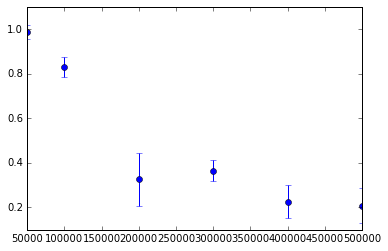

In [43]:
run_data = batch_run.get_model_vars_dataframe()
xs = [l.total_value for l in run_data.landscape]
ys = run_data.Omni_ratio
d={}
for x, y in zip(xs,ys):
    if not x in d:
        d[x] = [y]
    else:
        d[x].append(y)
ks=[]
vs=[]
ves=[]
for k,v in d.items():
    ks.append(k)
    vs.append(np.mean(v))
    ves.append(np.std(v))
plt.errorbar(ks, vs, yerr=ves, fmt='o')

In [44]:
from mesa.batchrunner import BatchRunner

landscapes = []
for pc in [float(x)/10 for x in range(7)]:
    landscapes.append(Landscape(
        width=101, 
        height=101, 
        max_value=50,
        total_value=100000,
        num_peaks=1000,
        peak_clustering=pc))

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    landscape=landscapes
)

batch_run = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=9, 
    max_steps=89, 
    model_reporters={'Omni_ratio': omni_ratio}
)

batch_run.run_all()

<Container object of 3 artists>

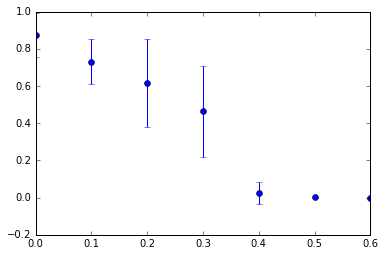

In [45]:
run_data = batch_run.get_model_vars_dataframe()
xs = [l.peak_clustering for l in run_data.landscape]
ys = run_data.Omni_ratio
d={}
for x, y in zip(xs,ys):
    if not x in d:
        d[x] = [y]
    else:
        d[x].append(y)
ks=[]
vs=[]
ves=[]
for k,v in d.items():
    ks.append(k)
    vs.append(np.mean(v))
    ves.append(np.std(v))
plt.errorbar(ks, vs, yerr=ves, fmt='o')

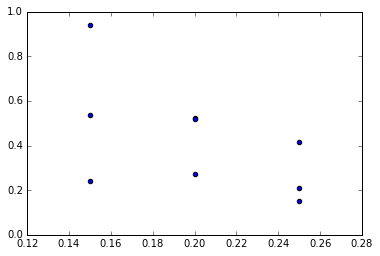

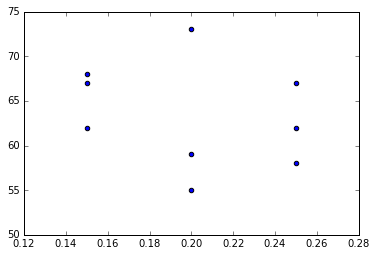

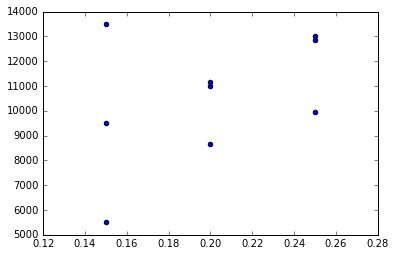

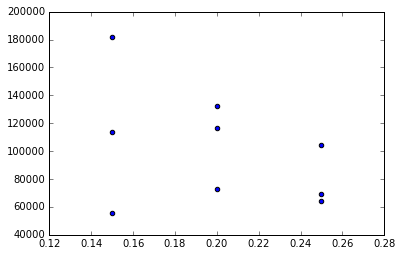

In [47]:
from mesa.batchrunner import BatchRunner

landscape = Landscape(
    width=101, 
    height=101, 
    max_value=50,
    total_value=100000,
    num_peaks=1000,
    peak_clustering=0.25
)

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    omni_threshold=[0.15,0.2,0.25],
    obli_threshold=3,
    continue_after_uniform=True,
    landscape=landscape
)

batch_run = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=3, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity
    }
)

batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()
plt.scatter(run_data.omni_threshold, run_data.omni_ratio)
plt.show()
plt.scatter(run_data.omni_threshold, run_data.total_pubs)
plt.show()
plt.scatter(run_data.omni_threshold, run_data.total_qual)
plt.show()
plt.scatter(run_data.omni_threshold, run_data.total_disp)
plt.show()

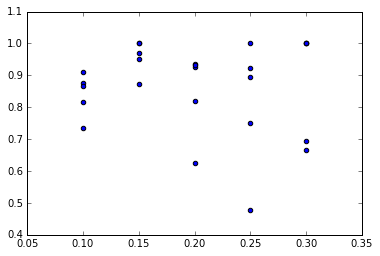

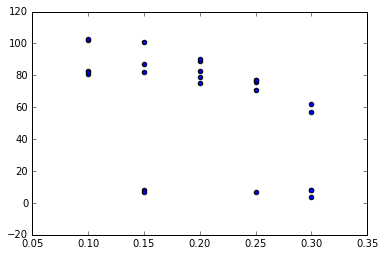

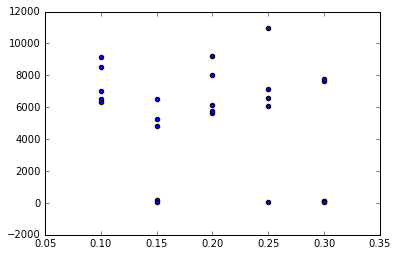

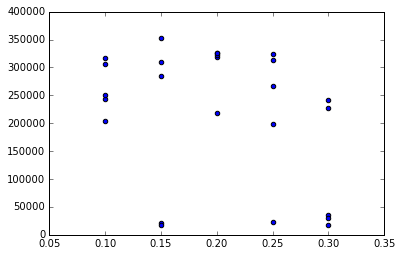

In [15]:
from mesa.batchrunner import BatchRunner

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    width=101, 
    height=101, 
    max_value=50,
    total_value=100000,
    num_peaks=1000,
    peak_clustering=0,
    episode_length=30,
    omni_threshold=[0.1,0.15,0.2,0.25,0.3],
    obli_threshold=3
)

batch_run = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity
    }
)

batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()
plt.scatter(run_data.omni_threshold, run_data.omni_ratio)
plt.show()
plt.scatter(run_data.omni_threshold, run_data.total_pubs)
plt.show()
plt.scatter(run_data.omni_threshold, run_data.total_qual)
plt.show()
plt.scatter(run_data.omni_threshold, run_data.total_disp)
plt.show()

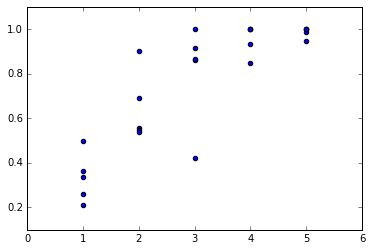

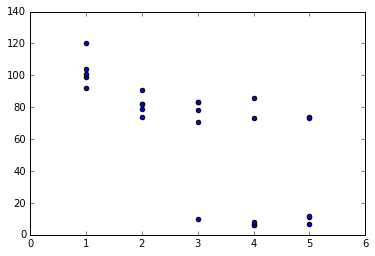

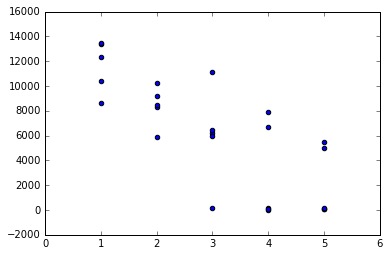

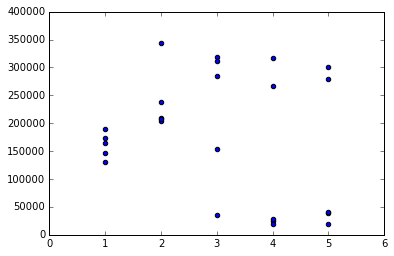

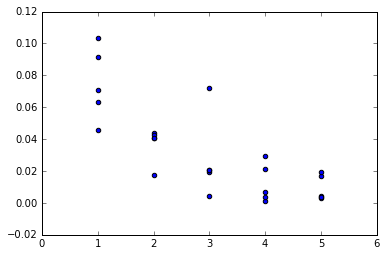

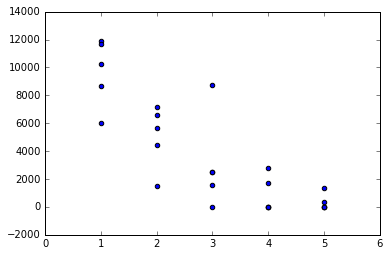

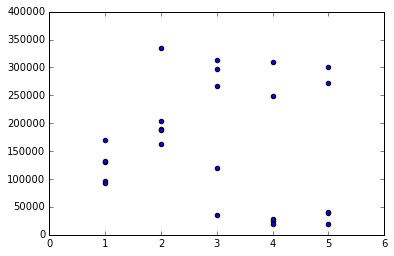

In [4]:
from mesa.batchrunner import BatchRunner

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    width=101, 
    height=101, 
    max_value=50,
    total_value=100000,
    num_peaks=1000,
    peak_clustering=0,
    episode_length=30,
    omni_threshold=0.2,
    obli_threshold=[1,2,3,4,5]
)

batch_run = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity,
        'q_d_ratio': quality_disparity_ratio,
        'obli_qual': count_obli_quality,
        'omni_disp': count_omni_disparity
    }
)

%prun batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()
plt.scatter(run_data.obli_threshold, run_data.omni_ratio)
plt.show()
plt.scatter(run_data.obli_threshold, run_data.total_pubs)
plt.show()
plt.scatter(run_data.obli_threshold, run_data.total_qual)
plt.show()
plt.scatter(run_data.obli_threshold, run_data.total_disp)
plt.show()
plt.scatter(run_data.obli_threshold, run_data.q_d_ratio)
plt.show()
plt.scatter(run_data.obli_threshold, run_data.obli_qual)
plt.show()
plt.scatter(run_data.obli_threshold, run_data.omni_disp)
plt.show()

In [4]:
omni_favouring_landscape = Landscape(
    width=101, 
    height=101, 
    max_value=50,
    total_value=50000,
    num_peaks=1000,
    peak_clustering=0)

neutral_landscape = Landscape(
    width=101, 
    height=101, 
    max_value=50,
    total_value=100000,
    num_peaks=1000,
    peak_clustering=0.2)

obli_favouring_landscape = Landscape(
    width=101, 
    height=101, 
    max_value=50,
    total_value=500000,
    num_peaks=1000,
    peak_clustering=0.4)

In [5]:
def plot_with_errorbars(xs, ys):
    d={}
    for x, y in zip(xs,ys):
        if not x in d:
            d[x] = [y]
        else:
            d[x].append(y)
    ks=[]
    vs=[]
    ves=[]
    for k,v in d.items():
        ks.append(k)
        vs.append(np.mean(v))
        ves.append(np.std(v))
    plt.errorbar(ks, vs, yerr=ves, fmt='o')
    plt.show()

In [53]:
from mesa.batchrunner import BatchRunner

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    omni_threshold=[0.1,0.15,0.2,0.25,0.3],
    obli_threshold=3,
    continue_after_uniform=True,
    landscape=omni_favouring_landscape
)

batch_run = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity
    }
)

batch_run.run_all()

### Omni favouring landscape ###


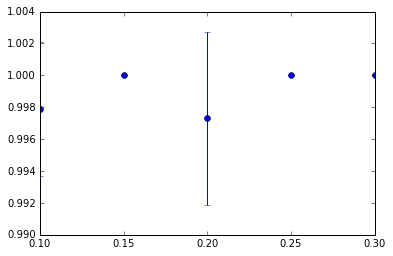

omni ratio


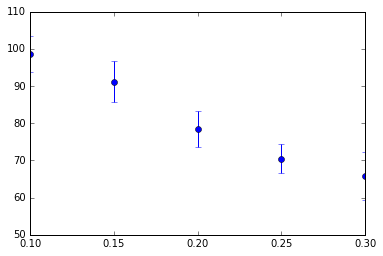

total pubs


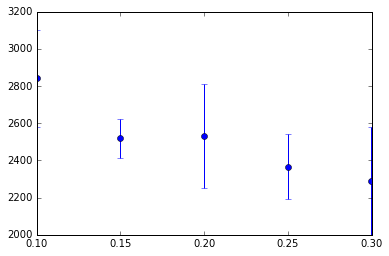

total qual


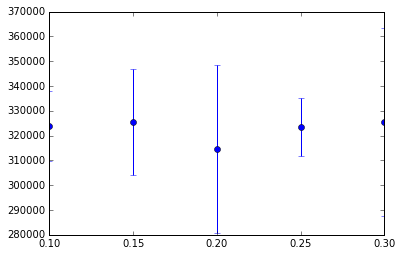

total disp


In [54]:
run_data = batch_run.get_model_vars_dataframe()
print("### Omni favouring landscape ###")
plot_with_errorbars(run_data.omni_threshold, run_data.omni_ratio)
print("omni ratio")
plot_with_errorbars(run_data.omni_threshold, run_data.total_pubs)
print("total pubs")
plot_with_errorbars(run_data.omni_threshold, run_data.total_qual)
print("total qual")
plot_with_errorbars(run_data.omni_threshold, run_data.total_disp)
print("total disp")

In [55]:
from mesa.batchrunner import BatchRunner

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    omni_threshold=0.2,
    obli_threshold=[1,2,3,4,5],
    continue_after_uniform=True,
    landscape=omni_favouring_landscape
)

batch_run1 = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity
    }
)

batch_run1.run_all()

### Omni favouring landscape ###


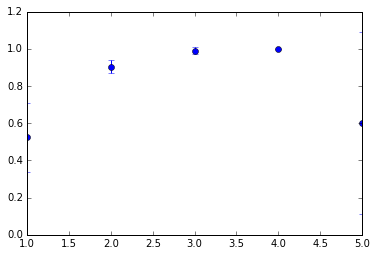

omni ratio


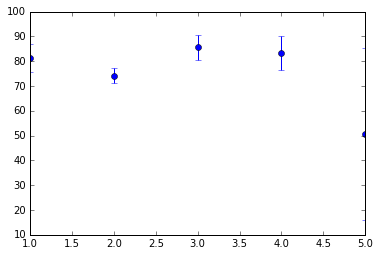

total pubs


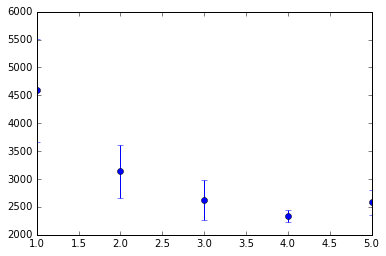

total qual


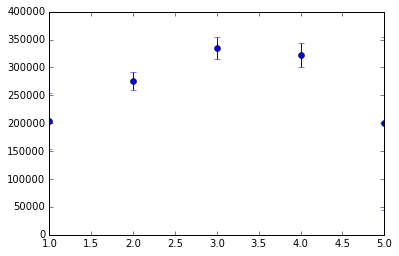

total disp


In [56]:
run_data1 = batch_run1.get_model_vars_dataframe()
print("### Omni favouring landscape ###")
plot_with_errorbars(run_data1.obli_threshold, run_data1.omni_ratio)
print("omni ratio")
plot_with_errorbars(run_data1.obli_threshold, run_data1.total_pubs)
print("total pubs")
plot_with_errorbars(run_data1.obli_threshold, run_data1.total_qual)
print("total qual")
plot_with_errorbars(run_data1.obli_threshold, run_data1.total_disp)
print("total disp")

In [58]:
from mesa.batchrunner import BatchRunner

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    omni_threshold=0.2,
    obli_threshold=[1,2,3,4,5],
    continue_after_uniform=True,
    landscape=obli_favouring_landscape
)

batch_run2 = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity
    }
)

batch_run2.run_all()

### Obli favouring landscape ###


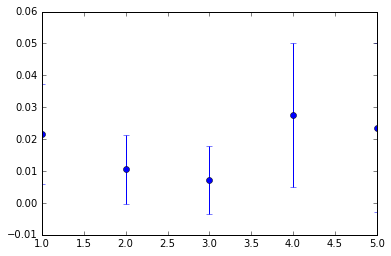

omni ratio


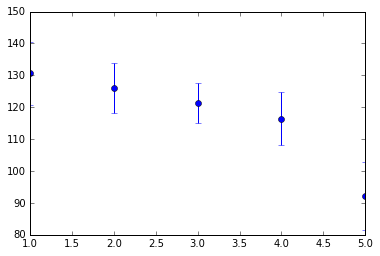

total pubs


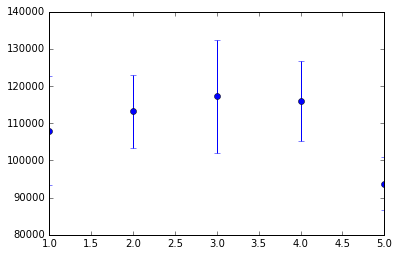

total qual


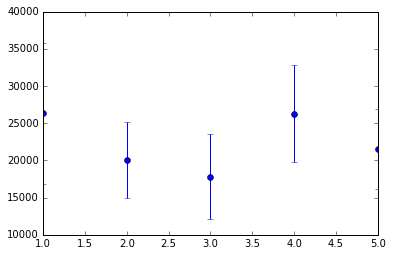

total disp


In [61]:
run_data2 = batch_run2.get_model_vars_dataframe()
print("### Obli favouring landscape ###")
plot_with_errorbars(run_data2.obli_threshold, run_data2.omni_ratio)
print("omni ratio")
plot_with_errorbars(run_data2.obli_threshold, run_data2.total_pubs)
print("total pubs")
plot_with_errorbars(run_data2.obli_threshold, run_data2.total_qual)
print("total qual")
plot_with_errorbars(run_data2.obli_threshold, run_data2.total_disp)
print("total disp")

In [60]:
from mesa.batchrunner import BatchRunner

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    omni_threshold=[0.1,0.15,0.2,0.25,0.3],
    obli_threshold=3,
    continue_after_uniform=True,
    landscape=obli_favouring_landscape
)

batch_run3 = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity
    }
)

batch_run3.run_all()

### Obli favouring landscape ###


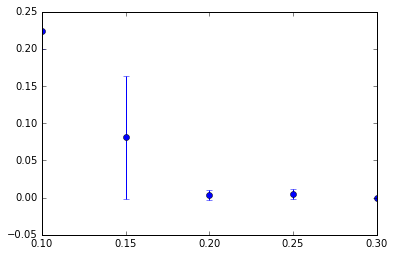

omni ratio


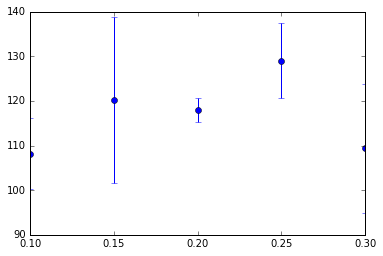

total pubs


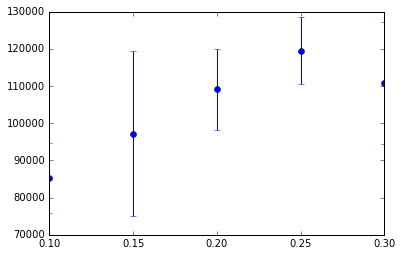

total qual


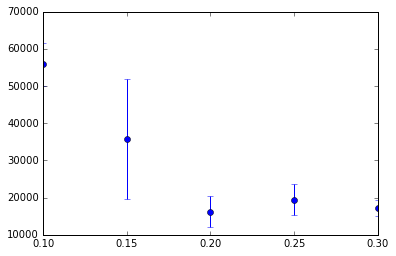

total disp


In [62]:
run_data3 = batch_run3.get_model_vars_dataframe()
print("### Obli favouring landscape ###")
plot_with_errorbars(run_data3.omni_threshold, run_data3.omni_ratio)
print("omni ratio")
plot_with_errorbars(run_data3.omni_threshold, run_data3.total_pubs)
print("total pubs")
plot_with_errorbars(run_data3.omni_threshold, run_data3.total_qual)
print("total qual")
plot_with_errorbars(run_data3.omni_threshold, run_data3.total_disp)
print("total disp")

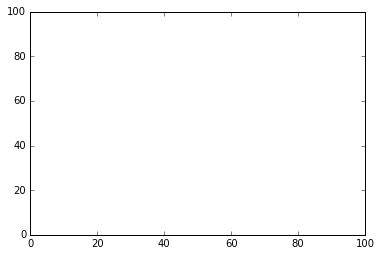

In [5]:
import matplotlib.animation as animation
import types

landscape = Landscape(
    width=101, 
    height=101, 
    max_value=50,
    total_value=100000,
    num_peaks=1000,
    peak_clustering=0.25
)

model = DiversityModel(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    landscape=landscape
)

m = np.mgrid[:model.width, :model.height]

fig = plt.figure()
ims = []

for i in range(300):
    model.step()
    im = plt.contourf(m[0], m[1], model.landscape, vmax=model.max_value)
        
    def setvisible(self, vis):
        for c in self.collections:
            c.set_visible(vis)
    im.set_visible = types.MethodType(setvisible, im)
    def setanimated(self, anim):
        for c in self.collections:
            c.set_animated(anim)
    im.set_animated = types.MethodType(setanimated, im)
    im.axes = plt.gca()
    
    texts = []
    for agent in model.schedule.agents:
        text = im.axes.text(agent.pos[0]-0.5, agent.pos[1]-0.5, agent.strategy[1], color='white')
        texts.append(text)
    ims.append([im]+texts)

ani = animation.ArtistAnimation(fig, ims, interval=5000, blit=False, repeat_delay=False)
ani.save('animated_diversity_longer.mp4', writer=animation.FFMpegFileWriter())

In [6]:
from mesa.batchrunner import BatchRunner

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    omni_threshold=0.2,
    obli_threshold=[1,2,3,4,5],
    continue_after_uniform=True,
    landscape=neutral_landscape
)

batch_run4 = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity
    }
)

batch_run4.run_all()

### Neutral landscape, obli bias ###
omni ratio


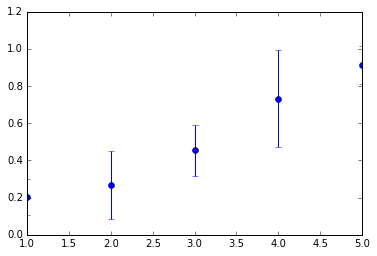

total pubs


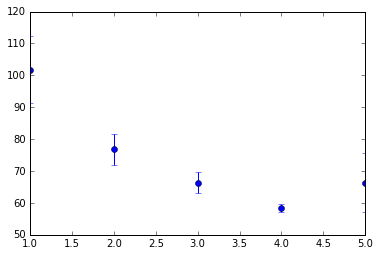

total qual


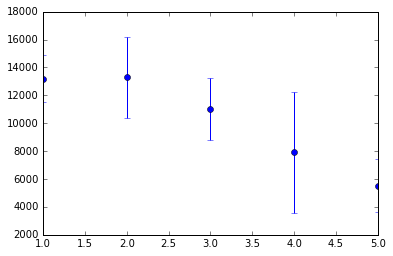

total disp


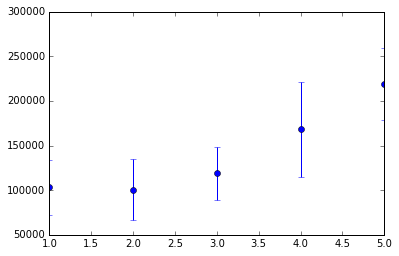

In [8]:
run_data4 = batch_run4.get_model_vars_dataframe()
print("### Neutral landscape, obli bias ###")
print("omni ratio")
plot_with_errorbars(run_data4.obli_threshold, run_data4.omni_ratio)
print("total pubs")
plot_with_errorbars(run_data4.obli_threshold, run_data4.total_pubs)
print("total qual")
plot_with_errorbars(run_data4.obli_threshold, run_data4.total_qual)
print("total disp")
plot_with_errorbars(run_data4.obli_threshold, run_data4.total_disp)

In [9]:
from mesa.batchrunner import BatchRunner

parameters = dict(
    num_agents=40,
    init_omni_ratio=0.5,
    episode_length=30,
    omni_threshold=[0.1,0.15,0.2,0.25,0.3],
    obli_threshold=3,
    continue_after_uniform=True,
    landscape=neutral_landscape
)

batch_run5 = BatchRunner(
    DiversityModel, 
    parameters, 
    iterations=5, 
    max_steps=89, 
    model_reporters={
        'omni_ratio': omni_ratio,
        'total_pubs': count_total_publications,
        'total_qual': count_total_quality,
        'total_disp': count_total_disparity
    }
)

batch_run5.run_all()

### Neutral landscape, omni bias ###


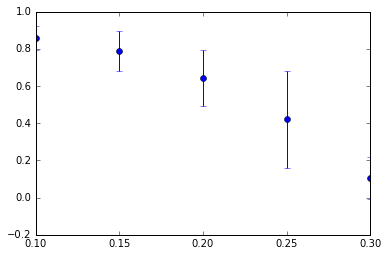

omni ratio


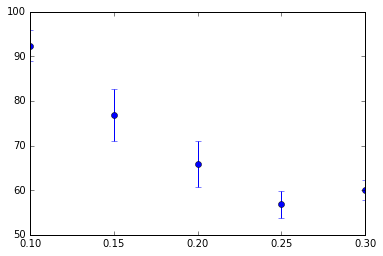

total pubs


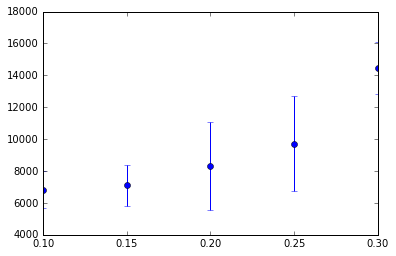

total qual


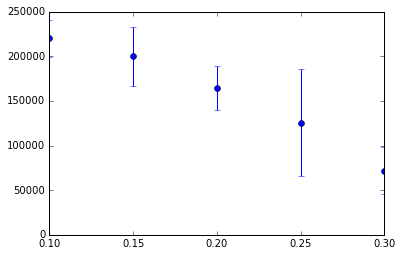

total disp


In [10]:
run_data5 = batch_run5.get_model_vars_dataframe()
print("### Neutral landscape, omni bias ###")
plot_with_errorbars(run_data5.omni_threshold, run_data5.omni_ratio)
print("omni ratio")
plot_with_errorbars(run_data5.omni_threshold, run_data5.total_pubs)
print("total pubs")
plot_with_errorbars(run_data5.omni_threshold, run_data5.total_qual)
print("total qual")
plot_with_errorbars(run_data5.omni_threshold, run_data5.total_disp)
print("total disp")

In [35]:
.41/0.27

1.5185185185185184

#####